In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow import keras
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dataset


from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor()
])

In [ ]:
data = dataset.ImageFolder('/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets' , transform = transform)

In [ ]:
VGG_model_path = "/content/drive/MyDrive/msc_project/VGG_model_lung_canc.pt"
resnet_model_path = "/content/drive/MyDrive/msc_project/resnet_model_lung_canc.pt"
desnet_model_path = "/content/drive/MyDrive/msc_project/desnet_model_lung_canc.pt"

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
datalen = len(data)
dataidx = np.array(list(range(datalen)))
np.random.shuffle(dataidx)

splitfrac = 0.9
split_idx = int(splitfrac * datalen)
train_idxs = dataidx[:split_idx]
valid_idxs = dataidx[split_idx:]

testsplit = 0.1
testidxs = int(testsplit * len(train_idxs))


test_idxs = train_idxs[:testidxs]
train_idxs = train_idxs[testidxs:]

np.random.shuffle(test_idxs)

In [ ]:
batch_size = 30

In [ ]:
len(data) / batch_size

500.0

In [ ]:
train_samples = torch.utils.data.SubsetRandomSampler(train_idxs)
valid_samples = torch.utils.data.SubsetRandomSampler(valid_idxs)
test_samples  = torch.utils.data.SubsetRandomSampler(test_idxs)
dataloader = DataLoader(data , batch_size = batch_size , sampler = train_samples)
validloader = DataLoader(data , batch_size = batch_size ,sampler = valid_samples)
testloader  = DataLoader(data , batch_size = batch_size , sampler = test_samples)

In [ ]:
import tensorflow
from torchvision import models
from tensorflow import keras
from keras.preprocessing import image
from collections import defaultdict

def keras_inception_resnet_prediction(image_path):
  inception_path = "/content/drive/MyDrive/msc_project/keras_inception_resnet_v2_weights.h5"
  inception_resnet_model = keras.models.load_model(inception_path)
  keras_image = image.load_img(image_path, target_size=(299, 299), color_mode='rgb')
  keras_image_tensor = image.img_to_array(keras_image)*(1.0/255.0)
  keras_image_tensor = np.asarray(torch.unsqueeze(torch.tensor(keras_image_tensor), 0))
  prediction_result = inception_resnet_model.predict(keras_image_tensor, batch_size=4)
  # prediction_result = np.argmax(prediction_result)
  # print("inception result:", prediction_result)
  return prediction_result


def ensemble_predict(image_path):
  image_lung = Image.open(image_path)

  cancer_categories = defaultdict(int)
  cancer_categories_array = np.zeros(3)

  VGG_MODEL = torch.load(VGG_model_path)
  RESNET_MODEL = torch.load(resnet_model_path)
  DESNET_MODEL = torch.load(desnet_model_path)

  image_tensor = transform(image_lung)
  image_tensor = torch.unsqueeze(image_tensor, 0)
  image_tensor = image_tensor.to(device)
  # print(image_tensor.shape)

  output_VGG = VGG_MODEL(image_tensor)
  output_RESNET = RESNET_MODEL(image_tensor)
  output_DESNET = DESNET_MODEL(image_tensor)
  ensemble_results = [output_VGG[0], output_RESNET[0], output_DESNET[0]]
  # ensemble_results = [output_VGG[0], output_RESNET[0], output_INCEPTION[0]*5]
  # print("VGGNET predict：", output_VGG)
  # print("RESNET predict：", output_RESNET)
  # print("DENSE predict：", output_DESNET)

  
  for item in ensemble_results:
    item = item.tolist()
    if item.index(max(item)) == 0:
      cancer_categories["lung_aca"] += 1
      cancer_categories_array[0] += 1
    else:
      if item.index(max(item)) == 1:
        cancer_categories["lung_n"] += 1
        cancer_categories_array[1] += 1
      else:
        cancer_categories["lung_scc"] += 1
        cancer_categories_array[2] += 1
  # print("The vote result from 3 models：", max(cancer_categories, key=cancer_categories.get))
  return np.argmax(cancer_categories_array)







In [ ]:
def ensemble_test(image_tensor):
  cancer_categories = defaultdict(int)
  cancer_categories_array = np.zeros(3)

  VGG_MODEL = torch.load(VGG_model_path)
  RESNET_MODEL = torch.load(resnet_model_path)
  DESNET_MODEL = torch.load(desnet_model_path)

  output_VGG = VGG_MODEL(image_tensor)
  output_RESNET = RESNET_MODEL(image_tensor)
  output_DESNET = DESNET_MODEL(image_tensor)
  ensemble_results = [output_VGG[0], output_RESNET[0], output_DESNET[0]]
  # print("VGGNET predict：", output_VGG)
  # print("RESNET predict：", output_RESNET)
  # print("INCEPTION predict：", output_DESNET)

  
  for item in ensemble_results:
    item = item.tolist()
    if item.index(max(item)) == 0:
      cancer_categories["lung_aca"] += 1
      cancer_categories_array[0] += 1
    else:
      if item.index(max(item)) == 1:
        cancer_categories["lung_n"] += 1
        cancer_categories_array[1] += 1
      else:
        cancer_categories["lung_scc"] += 1
        cancer_categories_array[2] += 1
  # print("The vote result from 3 models：", max(cancer_categories, key=cancer_categories.get))
  return np.argmax(cancer_categories_array)

In [ ]:
def ensemble_second_test(image_path):
  image_lung = Image.open(image_path)

  cancer_categories = defaultdict(int)
  cancer_categories_array = np.zeros(3)

  VGG_MODEL = torch.load(VGG_model_path)
  RESNET_MODEL = torch.load(resnet_model_path)

  image_tensor = transform(image_lung)
  image_tensor = torch.unsqueeze(image_tensor, 0)
  image_tensor = image_tensor.to(device)
  print(image_tensor.shape)

  output_VGG = VGG_MODEL(image_tensor)
  output_RESNET = RESNET_MODEL(image_tensor)
  output_INCEPTION = keras_inception_resnet_prediction(image_path)
  ensemble_results = [output_VGG[0], output_RESNET[0], output_INCEPTION[0]*5]
  # print("VGGNET predict：", output_VGG)
  # print("RESNET predict：", output_RESNET)
  # print("INCEPTION predict：", output_INCEPTION*5)

  
  for item in ensemble_results:
    item = item.tolist()
    if item.index(max(item)) == 0:
      cancer_categories["lung_aca"] += 1
      cancer_categories_array[0] += 1
    else:
      if item.index(max(item)) == 1:
        cancer_categories["lung_n"] += 1
        cancer_categories_array[1] += 1
      else:
        cancer_categories["lung_scc"] += 1
        cancer_categories_array[2] += 1
  # print("The vote result from 3 models：", max(cancer_categories, key=cancer_categories.get))
  return np.argmax(cancer_categories_array)

  
  

In [ ]:
image_lung_aca = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1001.jpeg"
image_lung_n = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_n/lungn1001.jpeg"
image_lung_scc = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg"
print(ensemble_predict(image_lung_aca))

0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
ensemble_predict(image_lung_n)

1

In [ ]:
ensemble_predict(image_lung_scc)

2

In [ ]:
ensemble_second_test(image_lung_aca)

torch.Size([1, 3, 224, 224])


0

In [ ]:
testloader_new  = DataLoader(data , batch_size = 1 , sampler = test_samples)
print(len(testloader_new))

1350


In [ ]:
def test(loaders, use_cuda  = True):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    process_array = []
    correct_num = 0
    all_num = 0

    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = ensemble_test(data)       
        compare_result = output == target[0]
        print("compare result:", compare_result)
        all_num += 1
        if compare_result == True:
          correct_num += 1
          print("correct rate:", correct_num / all_num)
          process_array.append(correct_num / all_num)
        else:
          process_array.append(correct_num / all_num)
    return process_array

plot_array1 = test(testloader_new)

compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cuda:0')
correct rate: 1.0
compare result: tensor(True, device='cud

In [ ]:
def test_second(loaders, use_cuda  = True):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    process_array = []
    correct_num = 0
    all_num = 0

    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = ensemble_test_second(data)       
        compare_result = output == target[0]
        print("compare result:", compare_result)
        all_num += 1
        if compare_result == True:
          correct_num += 1
          print("correct rate:", correct_num / all_num)
          process_array.append(correct_num / all_num)
        else:
          process_array.append(correct_num / all_num)
    return process_array

plot_array2 = test_second(testloader_new)

NameError: ignored

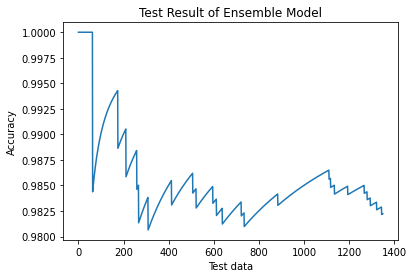

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig= plt.plot(plot_array1)
plt.title("Test Result of Ensemble Model")
plt.xlabel("Test data")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def test_single(loaders, model, criterion, use_cuda  = True):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    loss_track = []
    correct_track = []

    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        loss_track.append(test_loss)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        correct_track.append(correct/total)
        print("correct:", correct, "total:", total)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return loss_track, correct_track

In [ ]:
criterion = nn.CrossEntropyLoss().cuda()

In [ ]:
VGG_MODEL = torch.load(VGG_model_path)
RESNET_MODEL = torch.load(resnet_model_path)
DESNET_MODEL = torch.load(desnet_model_path)


In [ ]:
loss_track, correct_track = test_single(testloader_new, VGG_MODEL, criterion, use_cuda  = True)

correct: 1.0 total: 1.0
correct: 2.0 total: 2.0
correct: 3.0 total: 3.0
correct: 4.0 total: 4.0
correct: 5.0 total: 5.0
correct: 6.0 total: 6.0
correct: 7.0 total: 7.0
correct: 8.0 total: 8.0
correct: 9.0 total: 9.0
correct: 10.0 total: 10.0
correct: 11.0 total: 11.0
correct: 12.0 total: 12.0
correct: 13.0 total: 13.0
correct: 14.0 total: 14.0
correct: 15.0 total: 15.0
correct: 16.0 total: 16.0
correct: 17.0 total: 17.0
correct: 18.0 total: 18.0
correct: 19.0 total: 19.0
correct: 20.0 total: 20.0
correct: 21.0 total: 21.0
correct: 22.0 total: 22.0
correct: 23.0 total: 23.0
correct: 24.0 total: 24.0
correct: 25.0 total: 25.0
correct: 26.0 total: 26.0
correct: 27.0 total: 27.0
correct: 28.0 total: 28.0
correct: 29.0 total: 29.0
correct: 30.0 total: 30.0
correct: 31.0 total: 31.0
correct: 32.0 total: 32.0
correct: 33.0 total: 33.0
correct: 34.0 total: 34.0
correct: 35.0 total: 35.0
correct: 36.0 total: 36.0
correct: 37.0 total: 37.0
correct: 38.0 total: 38.0
correct: 39.0 total: 39.0
corr

In [ ]:
import matplotlib.pyplot as plt

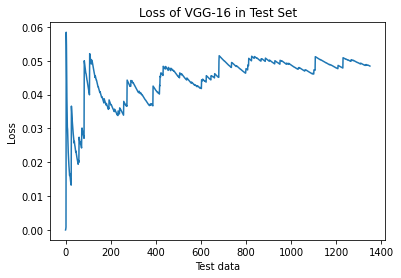

In [ ]:
fig = plt.plot(loss_track)
plt.xlabel("Test data")
plt.ylabel("Loss")
plt.title("Loss of VGG-16 in Test Set")
plt.show()

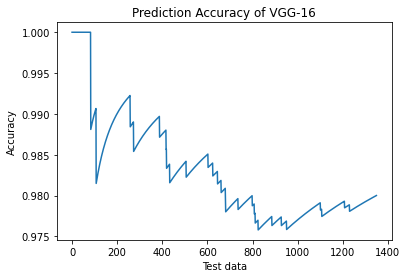

In [ ]:
fig1 = plt.plot(correct_track)
plt.xlabel("Test data")
plt.ylabel("Accuracy")
plt.title("Prediction Accuracy of VGG-16")
plt.show()

In [ ]:
loss_track_res, correct_track_res = test_single(testloader_new, RESNET_MODEL, criterion, use_cuda  = True)

correct: 1.0 total: 1.0
correct: 2.0 total: 2.0
correct: 3.0 total: 3.0
correct: 4.0 total: 4.0
correct: 5.0 total: 5.0
correct: 6.0 total: 6.0
correct: 7.0 total: 7.0
correct: 8.0 total: 8.0
correct: 9.0 total: 9.0
correct: 10.0 total: 10.0
correct: 11.0 total: 11.0
correct: 12.0 total: 12.0
correct: 13.0 total: 13.0
correct: 14.0 total: 14.0
correct: 15.0 total: 15.0
correct: 16.0 total: 16.0
correct: 17.0 total: 17.0
correct: 18.0 total: 18.0
correct: 19.0 total: 19.0
correct: 20.0 total: 20.0
correct: 21.0 total: 21.0
correct: 22.0 total: 22.0
correct: 23.0 total: 23.0
correct: 24.0 total: 24.0
correct: 25.0 total: 25.0
correct: 26.0 total: 26.0
correct: 27.0 total: 27.0
correct: 28.0 total: 28.0
correct: 29.0 total: 29.0
correct: 30.0 total: 30.0
correct: 31.0 total: 31.0
correct: 32.0 total: 32.0
correct: 33.0 total: 33.0
correct: 34.0 total: 34.0
correct: 35.0 total: 35.0
correct: 36.0 total: 36.0
correct: 37.0 total: 37.0
correct: 38.0 total: 38.0
correct: 39.0 total: 39.0
corr

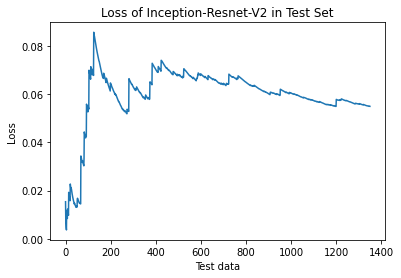

In [ ]:
fig2 = plt.plot(loss_track_res)
plt.xlabel("Test data")
plt.ylabel("Loss")
plt.title("Loss of Inception-Resnet-V2 in Test Set")
plt.show()

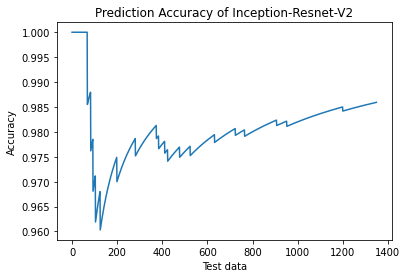

In [ ]:
fig3 = plt.plot(correct_track_res)
plt.xlabel("Test data")
plt.ylabel("Accuracy")
plt.title("Prediction Accuracy of Inception-Resnet-V2")
plt.show()

In [ ]:
loss_track_des, correct_track_des = test_single(testloader_new, DESNET_MODEL, criterion, use_cuda  = True)

correct: 1.0 total: 1.0
correct: 2.0 total: 2.0
correct: 3.0 total: 3.0
correct: 4.0 total: 4.0
correct: 5.0 total: 5.0
correct: 6.0 total: 6.0
correct: 7.0 total: 7.0
correct: 8.0 total: 8.0
correct: 9.0 total: 9.0
correct: 10.0 total: 10.0
correct: 11.0 total: 11.0
correct: 12.0 total: 12.0
correct: 13.0 total: 13.0
correct: 14.0 total: 14.0
correct: 15.0 total: 15.0
correct: 16.0 total: 16.0
correct: 17.0 total: 17.0
correct: 18.0 total: 18.0
correct: 19.0 total: 19.0
correct: 20.0 total: 20.0
correct: 21.0 total: 21.0
correct: 22.0 total: 22.0
correct: 23.0 total: 23.0
correct: 24.0 total: 24.0
correct: 25.0 total: 25.0
correct: 26.0 total: 26.0
correct: 27.0 total: 27.0
correct: 27.0 total: 28.0
correct: 28.0 total: 29.0
correct: 29.0 total: 30.0
correct: 30.0 total: 31.0
correct: 31.0 total: 32.0
correct: 32.0 total: 33.0
correct: 33.0 total: 34.0
correct: 34.0 total: 35.0
correct: 35.0 total: 36.0
correct: 36.0 total: 37.0
correct: 37.0 total: 38.0
correct: 38.0 total: 39.0
corr

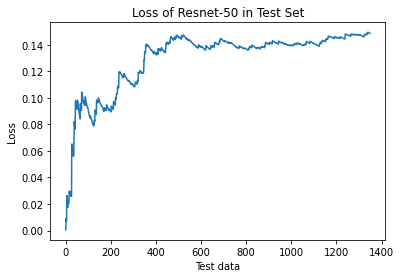

In [ ]:
fig4 = plt.plot(loss_track_des)
plt.xlabel("Test data")
plt.ylabel("Loss")
plt.title("Loss of Resnet-50 in Test Set")
plt.show()

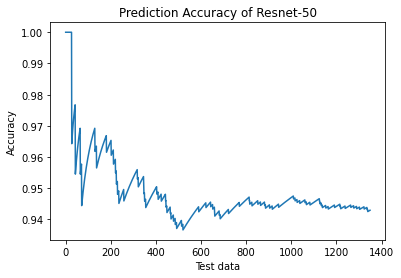

In [ ]:
fig5 = plt.plot(correct_track_des)
plt.xlabel("Test data")
plt.ylabel("Accuracy")
plt.title("Prediction Accuracy of Resnet-50")
plt.show()

In [ ]:
boxplot_data = [plot_array1, correct_track, correct_track_res, correct_track_des]
ax = sns.boxplot(data=boxplot_data)

AttributeError: ignored